In [7]:
import numpy as np
import torch, torchvision
from sklearn.decomposition import PCA
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd

# Suppress ConvergenceWarning when max_iter is small
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Loading Fashion MNIST dataset
train_set = torchvision.datasets.FashionMNIST("./data", download=True)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False)

X_train = train_set.data.numpy()
y_train = train_set.targets.numpy()
X_test = test_set.data.numpy()
y_test = test_set.targets.numpy()

# Reshaping and normalizing
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_train = X_train/255.0
X_test = X_test/255.0

In [8]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


# Downsampling with PCA

In [9]:
# Number of principal vectors
q = 185

# Projecting d-dimensional data into q-dimensions
pca = PCA(n_components=q)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# print("Explained variance ratio: ", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio: ", np.sum(pca.explained_variance_ratio_))

Cumulative explained variance ratio:  0.9488954590068888


# Model: Logistic Regression

In [23]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_pca, y_train)
print("Training accuracy: ", model.score(X_train_pca, y_train))
print("Test accuracy: ", model.score(X_test_pca, y_test))

Training accuracy:  0.8635
Test accuracy:  0.843


## Tuning C

In [27]:
# Hyperparameter values
C_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1e10]
n = X_train_pca.shape[0]

# Storing average validation accuracies for each bootsrap dataset
avg_train_accuracies, avg_val_accuracies = [[], []]

# initializing KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=28)

# Non-parametric bootstrap
for C in C_vals:
    print("Performing 5-fold CV for C = ", C)
    train_accs, val_accs = [[], []]
    
    # Loop over folds
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Training
        model = LogisticRegression(penalty='l2', C=C, solver='lbfgs')
        model.fit(X_train_fold, y_train_fold)

        # Computing accuracies on the training and validation fold
        train_accs.append(model.score(X_train_fold, y_train_fold)) 
        val_accs.append(model.score(X_val_fold, y_val_fold))

    # Storing average training and validation accuracies for this C
    avg_train_accuracies.append(np.mean(train_accs)) 
    avg_val_accuracies.append(np.mean(val_accs))

Performing 5-fold CV for C =  0.001
Performing 5-fold CV for C =  0.01
Performing 5-fold CV for C =  0.1
Performing 5-fold CV for C =  1
Performing 5-fold CV for C =  10
Performing 5-fold CV for C =  100
Performing 5-fold CV for C =  10000000000.0


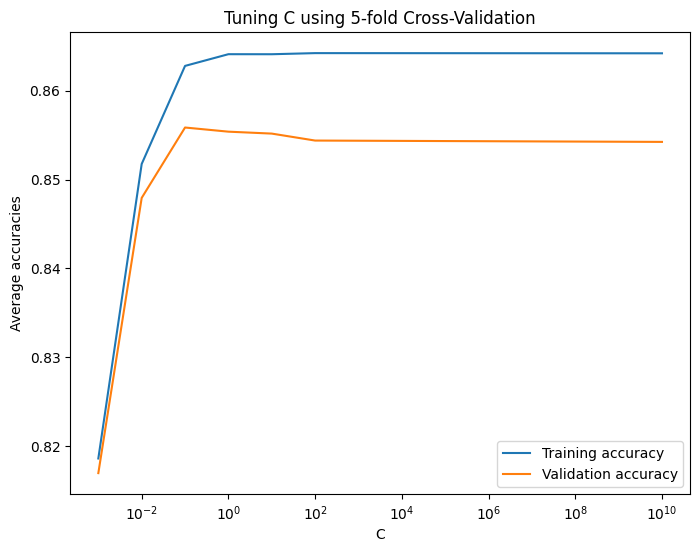

In [29]:
# Plot 
plt.figure(figsize=(8, 6))
plt.semilogx(C_vals, avg_train_accuracies, label='Training accuracy')
plt.semilogx(C_vals, avg_val_accuracies, label='Validation accuracy')
plt.xlabel(r'C')
plt.ylabel('Average accuracies')
plt.title('Tuning C using 5-fold Cross-Validation')
plt.legend(loc='lower right')

plt.savefig('LogReg_FashionMNIST_5-foldCV.pdf', bbox_inches='tight')

In [35]:
results_df = pd.DataFrame({'C': C_vals,
                          'Avg. Training Acc.': avg_train_accuracies,
                          'Avg. Validation Acc.': avg_val_accuracies})

results_df.sort_values(by='Avg. Validation Acc.', ascending=False)

,C,Avg. Training Acc.,Avg. Validation Acc.
2,1.000000e-01,0.862779,0.855850
3,1.000000e+00,0.864096,0.855383
4,1.000000e+01,0.864092,0.855167
5,1.000000e+02,0.864217,0.854383
6,1.000000e+10,0.864196,0.854233
1,1.000000e-02,0.851750,0.847933
0,1.000000e-03,0.818629,0.816983


## No regularization

In [36]:
model = LogisticRegression(penalty=None, solver='lbfgs')
model.fit(X_train_pca, y_train)
print("Training accuracy: ", model.score(X_train_pca, y_train))
print("Test accuracy: ", model.score(X_test_pca, y_test))

Training accuracy:  0.86305
Test accuracy:  0.8437


## Tuning max_iter

In [37]:
# Hyperparameter values
max_iters = [10, 50, 100, 150, 300]
n = X_train_pca.shape[0]

# Storing average validation accuracies for each bootsrap dataset
avg_train_accuracies, avg_val_accuracies = [[], []]

# initializing KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=28)

# Non-parametric bootstrap
for max_iter in max_iters:
    print("Performing 5-fold CV for max_iter = ", max_iter)
    train_accs, val_accs = [[], []]
    
    # Loop over folds
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Training
        model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=max_iter)
        model.fit(X_train_fold, y_train_fold)

        # Computing accuracies on the training and validation fold
        train_accs.append(model.score(X_train_fold, y_train_fold)) 
        val_accs.append(model.score(X_val_fold, y_val_fold))

    # Storing average training and validation accuracies for this C
    avg_train_accuracies.append(np.mean(train_accs)) 
    avg_val_accuracies.append(np.mean(val_accs))

Performing 5-fold CV for max_iter =  10
Performing 5-fold CV for max_iter =  50
Performing 5-fold CV for max_iter =  100
Performing 5-fold CV for max_iter =  150
Performing 5-fold CV for max_iter =  300


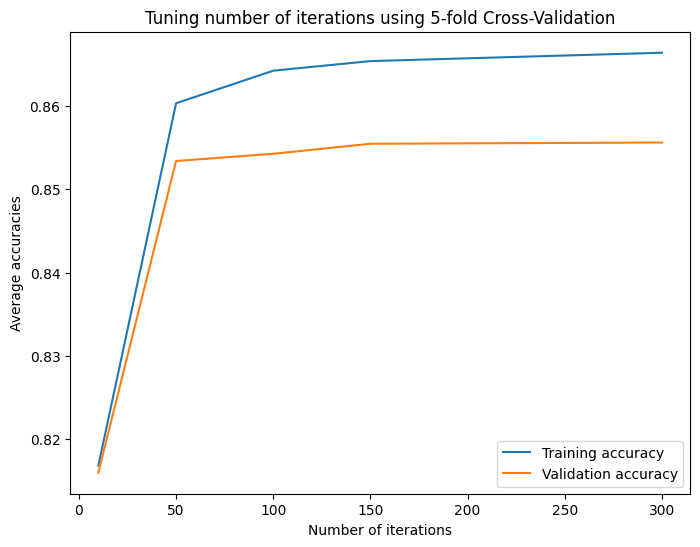

In [39]:
# Plot 
plt.figure(figsize=(8, 6))
plt.plot(max_iters, avg_train_accuracies, label='Training accuracy')
plt.plot(max_iters, avg_val_accuracies, label='Validation accuracy')
plt.xlabel('Number of iterations')
plt.ylabel('Average accuracies')
plt.title('Tuning number of iterations using 5-fold Cross-Validation')
plt.legend(loc='lower right')

plt.savefig('LogReg_FashionMNIST_5-foldCV_2.pdf', bbox_inches='tight')

In [40]:
results_df = pd.DataFrame({'max_iter': max_iters,
                          'Avg. Training Acc.': avg_train_accuracies,
                          'Avg. Validation Acc.': avg_val_accuracies})

results_df.sort_values(by='Avg. Validation Acc.', ascending=False)

,max_iter,Avg. Training Acc.,Avg. Validation Acc.
4,300,0.866346,0.855583
3,150,0.865342,0.855433
2,100,0.864192,0.854233
1,50,0.860287,0.853367
0,10,0.816850,0.816000


**Remark**: Higher number of iterations increases runtime significantly without much improvement to the validation accuracy

# Confidence Interval

# 🧍🏽‍♀️

In [ ]:
...

# Final Evaluation

In [41]:
#%% final evaluation with best hyperparameters
model = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=100)
model.fit(X_train_pca, y_train)
print("Training accuracy:", model.score(X_train_pca, y_train))
print("Test accuracy:", model.score(X_test_pca, y_test))

Training accuracy: 0.8619833333333333
Test accuracy: 0.8421


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

# make predictions
y_pred = model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print or use the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8421
Precision: 0.8406782392548506
Recall: 0.8421
F1 Score: 0.8410904847637656


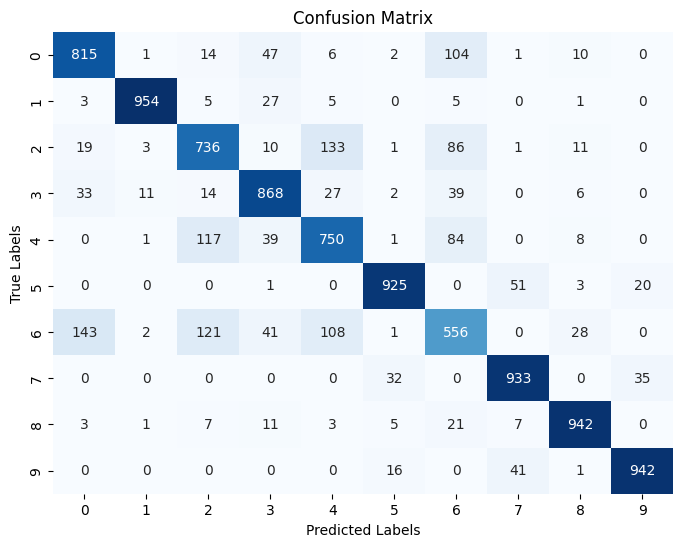

In [45]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('LogReg_FashionMNIST_ConfMat.pdf', bbox_inches='tight')